In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"  # eseguire se non è stato installato in precedenza

In [ ]:
!pip install -q tf-models-official==2.7.0   # eseguire se non è stato installato in precedenza

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np
import csv

tf.get_logger().setLevel('ERROR')

In [2]:
tf.__version__

'2.8.0'

In [3]:
DATASET = "./sentDataset/training.1600000.processed.noemoticon.csv"


X = []
y = []

NUM_REC = 10000  # Ho dovuto riportare i record a 10.000 perché il triplo input e 
                 # la grandezza della rete BERT prendevano tutta la memoria rendevano impossibile l'addestramento con 50.000

num_pos = 0
num_neg = 0
with open(DATASET, 'r') as f:
    reader = csv.reader(f)
    for line in reader:
        
        if num_pos > NUM_REC and num_neg > NUM_REC:
            break
            
        g = int(line[0])
        if g > 2:
            g = 1
            num_pos += 1
            if num_pos <= NUM_REC:
                y.append(g)
                X.append(line[5])
        elif g < 2:
            g = 0
            num_neg += 1
            if num_neg <= NUM_REC:
                y.append(g) 
                X.append(line[5])
         


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
#AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

#raw_train_ds = X_train #tf.keras.utils.text_dataset_from_directory(

class_names = [0,1]

train_ds = X_train #raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = X_test # tf.keras.utils.text_dataset_from_directory(

#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [6]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611872  0.3667386   0.15233792  0.65504557
  0.9681154  -0.948627    0.00216077 -0.9877732   0.06842785 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946352  0.34321296  0.3323149  ...  0.2130083   0.71020764
  -0.05771133]
 [-0.2874205   0.31981108 -0.2301845  ...  0.5845506  -0.2132971
   0.7269202 ]
 [-0.6615705   0.6887687  -0.8743301  ...  0.10877223 -0.26173192
   0.47855487]
 ...
 [-0.22561216 -0.2892565  -0.07064489 ...  0.4756605   0.832772
   0.40025362]
 [-0.2982421  -0.2747309  -0.05450581 ...  0.48849702  1.095536
   0.18163332]
 [-0.44378197  0.00930689  0.07223699 ...  0.17290227  1.1833242
   0.07898021]]


In [12]:
for i in range(len(bert_model.weights)):  # per visualizzare i layer di cui si compone il modello
    print("In layer ", bert_model.weights[i].name)

In layer  word_embeddings/embeddings:0
In layer  position_embedding/embeddings:0
In layer  type_embeddings/embeddings:0
In layer  embeddings/layer_norm/gamma:0
In layer  embeddings/layer_norm/beta:0
In layer  transformer/layer_0/self_attention/query/kernel:0
In layer  transformer/layer_0/self_attention/query/bias:0
In layer  transformer/layer_0/self_attention/key/kernel:0
In layer  transformer/layer_0/self_attention/key/bias:0
In layer  transformer/layer_0/self_attention/value/kernel:0
In layer  transformer/layer_0/self_attention/value/bias:0
In layer  transformer/layer_0/self_attention/attention_output/kernel:0
In layer  transformer/layer_0/self_attention/attention_output/bias:0
In layer  transformer/layer_0/self_attention_layer_norm/gamma:0
In layer  transformer/layer_0/self_attention_layer_norm/beta:0
In layer  transformer/layer_0/intermediate/kernel:0
In layer  transformer/layer_0/intermediate/bias:0
In layer  transformer/layer_0/output/kernel:0
In layer  transformer/layer_0/output

In [13]:
# build classifier model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

classifier_model =  tf.keras.Model(text_input, net)


In [14]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

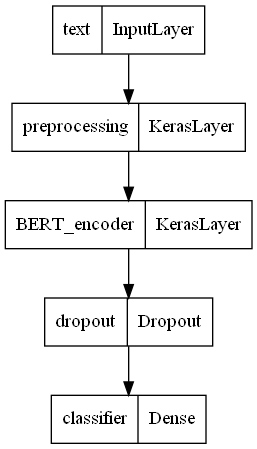

In [15]:
tf.keras.utils.plot_model(classifier_model)

In [16]:
print(text_test)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

['this is such an amazing movie!']
tf.Tensor([[0.69800055]], shape=(1, 1), dtype=float32)


In [18]:
epochs = 5
steps_per_epoch = len(train_ds) # tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

with tf.device("/device:CPU:0"):
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')

In [ ]:
#from tensorflow.python.client import device_lib

#def get_available_devices():
#    local_device_protos = device_lib.list_local_devices()
#    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [ ]:
#print(get_available_devices())
#cpus = tf.config.list_physical_devices('CPU')
#print(cpus)

In [19]:
metrics = [tf.keras.metrics.BinaryAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.BinaryCrossentropy()

with tf.device("/device:CPU:0"):
    classifier_model.compile(
                            optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

with tf.device("/device:CPU:0"):
    classifier_model.fit(x=X_train, y=y_train,validation_data=(X_test, y_test),batch_size=8,epochs=epochs)

Epoch 1/5
2000/2000 [==============================] - 4965s 2s/step - loss: 0.6297 - accuracy: 0.6488 - val_loss: 0.5271 - val_accuracy: 0.7490
Epoch 2/5
2000/2000 [==============================] - 5224s 3s/step - loss: 0.4941 - accuracy: 0.7695 - val_loss: 0.4826 - val_accuracy: 0.7753
Epoch 3/5
2000/2000 [==============================] - 5122s 3s/step - loss: 0.4343 - accuracy: 0.8116 - val_loss: 0.4874 - val_accuracy: 0.7880
Epoch 4/5
   3/2000 [..............................] - ETA: 47:40 - loss: 0.2426 - accuracy: 0.8750

KeyboardInterrupt: 

In [21]:
# ho dovuto interrompere l'addestramento precedente perché mi serviva il computer, che poi ho ripreso sotto con ulteriori 5 epoche

PATH_MODEL = "./models/"
classifier_model.save(PATH_MODEL + 'model_BertSent.h5')  # save the model to file


In [22]:
with tf.device("/device:CPU:0"):
    classifier_model.fit(x=X_train, y=y_train,validation_data=(X_test, y_test),batch_size=8,epochs=epochs)

Epoch 1/5
2000/2000 [==============================] - 4650s 2s/step - loss: 0.3806 - accuracy: 0.8494 - val_loss: 0.6043 - val_accuracy: 0.7688
Epoch 2/5
2000/2000 [==============================] - 4987s 2s/step - loss: 0.3223 - accuracy: 0.8912 - val_loss: 0.6983 - val_accuracy: 0.7835
Epoch 3/5
2000/2000 [==============================] - 4999s 2s/step - loss: 0.2551 - accuracy: 0.9288 - val_loss: 0.9505 - val_accuracy: 0.7872
Epoch 4/5
2000/2000 [==============================] - 7320s 4s/step - loss: 0.1975 - accuracy: 0.9507 - val_loss: 1.2000 - val_accuracy: 0.7903
Epoch 5/5
2000/2000 [==============================] - 7006s 4s/step - loss: 0.1559 - accuracy: 0.9642 - val_loss: 1.2405 - val_accuracy: 0.7828


Questo addestramento è stato fatto con 10.000 record perché il triplo input e la grandezza della rete BERT prendevano tutta la memoria rendevano impossibile l'addestramento con 50.000
Una prova ulteriore che sarebbe interessante fare e che vi invito a fare è preparare il dataset con 50.000 come nel file TweetSentAnalisys con cui stiamo facendo la comparazione, ma addestrare questa rete prima con 4 o 5 epoche sui primi 10000, e poi successivamente (ovviamente senza ricompilarla, mantenendo l'addestramento precedente) sui 10000 successivi.
Se qualcuno lo fa mi faccia sapere come va. Probabilmente lo faccio anch'io.